# Выпускной проект. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. В данном проекте решается задача регрессии.

### Описание этапа обработки:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных:

Данные состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Цель работы:
Нужно построить модель, которая предскажет температуру стали. Также необходимо добиться определенного значения метрики МАЕ <=6.8

### План работы:

- Загрузить данные и провести исследовательский анализ
- Сформировать результирующий набор данных
- Обучить модель регрессии. По рез-ту важности признаков вернутся к редактированию рез-го набора данных
- Ооформить вывод
- Составить отчёт о проделанной работе

## 1.Изучение данных

In [1]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install shap



Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


import shap
import time
import warnings
warnings.filterwarnings('ignore')

from tabulate import tabulate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
# Загрузим наши данные

# данные об электродах
try:
    data_arc = pd.read_csv('D:\Яндекс Практикум\final_progect\data_arc_new.csv')
except OSError as e:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

# данные о подаче сыпучих материалов (объём)
try:
    data_bulk = pd.read_csv('D:\Яндекс Практикум\final_progect\data_bulk_new.csv')
except OSError as e:
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

# данные о подаче сыпучих материалов (время)
try:
    data_bulk_time = pd.read_csv('D:\Яндекс Практикум\final_progect\data_bulk_time_new.csv')
except OSError as e:
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

# данные о продувке сплава газом
try:
    data_gas = pd.read_csv('D:\Яндекс Практикум\final_progect\data_gas_new.csv')
except OSError as e:
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

# результаты измерения температуры
try:
    data_temp = pd.read_csv('D:\Яндекс Практикум\final_progect\data_temp_new.csv')
except OSError as e:
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

#  данные о проволочных материалах (объём)
try:
    data_wire = pd.read_csv('D:\Яндекс Практикум\final_progect\data_wire_new.csv')
except OSError as e:
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

# данные о проволочных материалах (время)
try:
    data_wire_time = pd.read_csv('D:\Яндекс Практикум\final_progect\data_wire_time_new.csv')
except OSError as e:
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [6]:
# создадим функцию для первоначального анализа данных
def df_info(dataframe):
    column = dataframe.columns.values.tolist() # список наименований столбцов таблицы
    print('Общая информация о таблице:\n')
    dataframe.info() # общая информация о таблице
    print('\nВнешний вид таблицы :')
    display(dataframe.sample(5)) # внешний вид первых 5 строк таблицы

    # далее выводим все интересующие нас особенности таблицы, соответствнно, обозначенные в функции print()
    print('Столбцы таблицы: {}\n'.format(column),
          '\n\nОбщее количество уникальных значений столбцов {}:\n\n{}'.
          format(column, dataframe.nunique()),
          '\n\nКоличество пропущенных значений столбцов {}:\n\n{}'.
          format(column, dataframe.isna().sum()))

    for i in column: # создадим цикл для перебора значений столбцов для отдельного примнения к ним любой функции
          print('\n\nСоотношение дубликатов столбца {} ко всем строкам:\t {}'.format(i, dataframe[i].duplicated().mean()/len(dataframe)))
    print('\nСоотношение явных дубликтов ко всем строкам: {}'.format((dataframe.duplicated().mean()/len(dataframe))))
    print('\n\nТаблица корреляций значений столбцов {}:\n\n{}'.format(column, dataframe.corr()), '\n',
          '\n\nТаблица распределений значений столбцов {}:\n\n{}'.format(column, dataframe.describe()), '\n')

### Данные об электродах

In [7]:
df_info(data_arc)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Внешний вид таблицы :


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
13789,2991,2019-08-29 02:47:48,2019-08-29 02:50:20,0.360164,0.242152
3110,674,2019-05-29 18:00:03,2019-05-29 18:04:47,0.758528,0.486844
365,78,2019-05-06 09:30:16,2019-05-06 09:32:46,0.528280,0.371342
500,108,2019-05-07 09:50:30,2019-05-07 09:53:07,0.870068,0.651657
10822,2354,2019-08-05 01:45:01,2019-08-05 01:48:44,0.819564,0.558380


Столбцы таблицы: ['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность']
 

Общее количество уникальных значений столбцов ['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность']:

key                      3214
Начало нагрева дугой    14876
Конец нагрева дугой     14876
Активная мощность       13846
Реактивная мощность     14707
dtype: int64 

Количество пропущенных значений столбцов ['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность']:

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


Соотношение дубликатов столбца key ко всем строкам:	 5.269879656229239e-05


Соотношение дубликатов столбца Начало нагрева дугой ко всем строкам:	 0.0


Соотношение дубликатов столбца Конец нагрева дугой ко всем строкам:	 0.0


Соотношение дубликатов столбца Активная мощность ко вс

array([[<AxesSubplot:title={'center':'Активная мощность'}>,
        <AxesSubplot:title={'center':'Реактивная мощность'}>]],
      dtype=object)

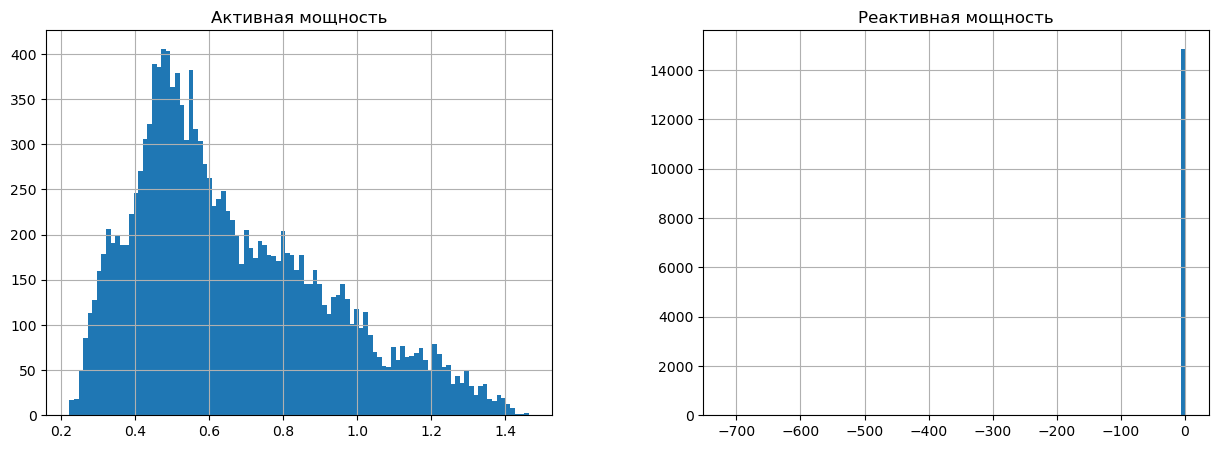

In [8]:
# Построем гистограммы для наших данных
data_arc_1=data_arc.drop('key', axis=1)
data_arc_1.hist(bins=100, figsize=(15,5))

#### Промежуточный вывод данных об электродах

Общее число строк 14876, столбцов 5( уникальный код, начало и конец нагрева, активная и реактивная мощность), судя по общей информации, пропусков нет, явных дубликатов нет. В глаза сразу бросается тип данных на временых значениях( вместо datetime стоит object). Корреляция между признаками слабоположительная и слабоотрицательная. Так же наблюдается выброс в признаке Реактивная мощность( минимальное значение -715 это явно нереалистичное значение)

### Данные о подаче сыпучих материалов (объём)

In [9]:
df_info(data_bulk)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Внешний вид таблицы :


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
606,636,NaN,NaN,245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,458.0,NaN,218.0,203.0
1984,2054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.0,NaN,101.0,104.0
1427,1481,NaN,NaN,NaN,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,103.0,105.0
1141,1189,NaN,NaN,NaN,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2352,2438,NaN,NaN,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316.0,NaN,184.0,213.0


Столбцы таблицы: ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
 

Общее количество уникальных значений столбцов ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']:

key        3129
Bulk 1       47
Bulk 2       15
Bulk 3      278
Bulk 4      206
Bulk 5       55
Bulk 6      205
Bulk 7       25
Bulk 8        1
Bulk 9       10
Bulk 10      77
Bulk 11     101
Bulk 12     331
Bulk 13      14
Bulk 14     284
Bulk 15     156
dtype: int64 

Количество пропущенных значений столбцов ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']:

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     310

<AxesSubplot:>

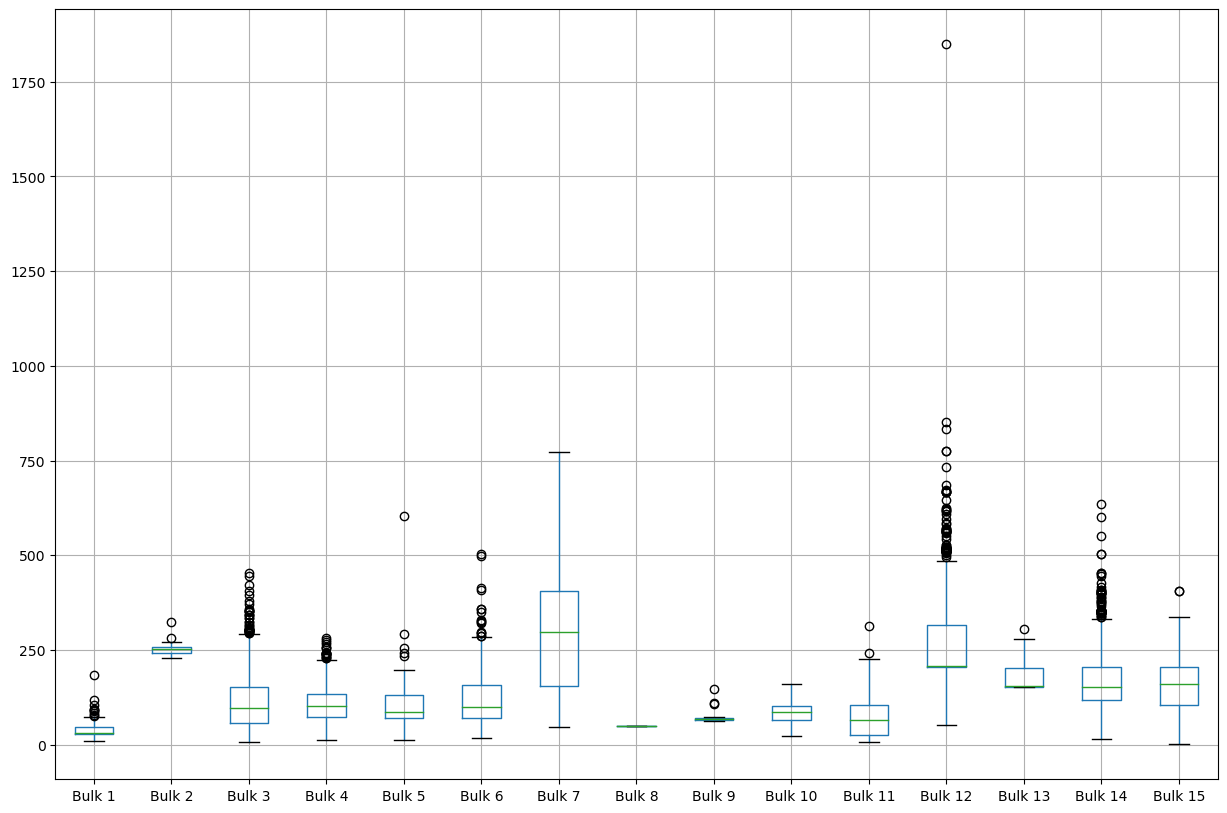

In [10]:
# Построим график boxplot для наглядного изучения данных без столбца key
data_bulk_1=data_bulk.drop('key', axis=1)
data_bulk_1.boxplot(figsize=(15, 10))

#### Промежуточный вывод данных о объеме сыпучих материалов

Общее кол-во строк 3129, столбцов 15, из них один-уникальный код, остальные - объем подаваемых материалов. Видны явные пропуски в данных( около 90%), дубликатов нет. Так как данные практически отсутствуют, то корреляция между признаками может быть не точной, но на данный момент присутствует среднеположительная/отрицательная корреляция. По диаграмме можно заметить аномалию в 8 сырье(всего одно значение на весь датасет равное 49), и явные выбросы в 12 измерении. Тип данных предоставлен верный.

### Данные о подаче сыпучих материалов (время)

In [11]:
df_info(data_bulk_time)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Внешний вид таблицы :


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2868,2974,NaN,NaN,2019-08-28 12:23:48,2019-08-28 12:31:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-28 12:28:35,NaN,2019-08-28 12:23:48,2019-08-28 12:17:26
2038,2110,2019-07-27 19:11:22,2019-07-27 19:11:22,NaN,2019-07-27 19:11:22,2019-07-27 19:11:22,NaN,2019-07-27 19:15:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1748,1809,NaN,NaN,2019-07-09 16:58:24,2019-07-09 16:53:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-09 16:50:40,NaN
606,636,NaN,NaN,2019-05-27 17:01:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-27 16:56:49,NaN,2019-05-27 16:48:58,2019-05-27 16:43:33
2322,2406,NaN,NaN,2019-08-07 08:38:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-07 08:35:59,NaN,2019-08-07 08:28:06,2019-08-07 08:13:07


Столбцы таблицы: ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
 

Общее количество уникальных значений столбцов ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']:

key        3129
Bulk 1      252
Bulk 2       22
Bulk 3     1298
Bulk 4     1014
Bulk 5       77
Bulk 6      576
Bulk 7       25
Bulk 8        1
Bulk 9       19
Bulk 10     176
Bulk 11     177
Bulk 12    2450
Bulk 13      18
Bulk 14    2806
Bulk 15    2248
dtype: int64 

Количество пропущенных значений столбцов ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']:

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     310

#### Промежуточный вывод данных о времени подачи сыпучих материалов

Данные аналогичны предыдущим. Столбцов 16: 1- уникальный код, остальные- время подаваемых веществ. Строк 3129. Пропуски, на первый взгляд, точно такие же, как и в данных об объеме( что наводит на определенные мысли). Корреляция между признаками отсутствует, так как нет числовых признаков, тип данных предоставлен неверный( формату datetime установили формат object)

### Данные о продувке сплава газом

In [12]:
df_info(data_gas)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Внешний вид таблицы :


,key,Газ 1
1952,1955,8.952893
1830,1833,9.542327
872,875,23.206485
469,472,5.352341
1851,1854,13.781657


Столбцы таблицы: ['key', 'Газ 1']
 

Общее количество уникальных значений столбцов ['key', 'Газ 1']:

key      3239
Газ 1    3239
dtype: int64 

Количество пропущенных значений столбцов ['key', 'Газ 1']:

key      0
Газ 1    0
dtype: int64


Соотношение дубликатов столбца key ко всем строкам:	 0.0


Соотношение дубликатов столбца Газ 1 ко всем строкам:	 0.0

Соотношение явных дубликтов ко всем строкам: 0.0


Таблица корреляций значений столбцов ['key', 'Газ 1']:

            key     Газ 1
key    1.000000 -0.040655
Газ 1 -0.040655  1.000000 
 

Таблица распределений значений столбцов ['key', 'Газ 1']:

               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040 



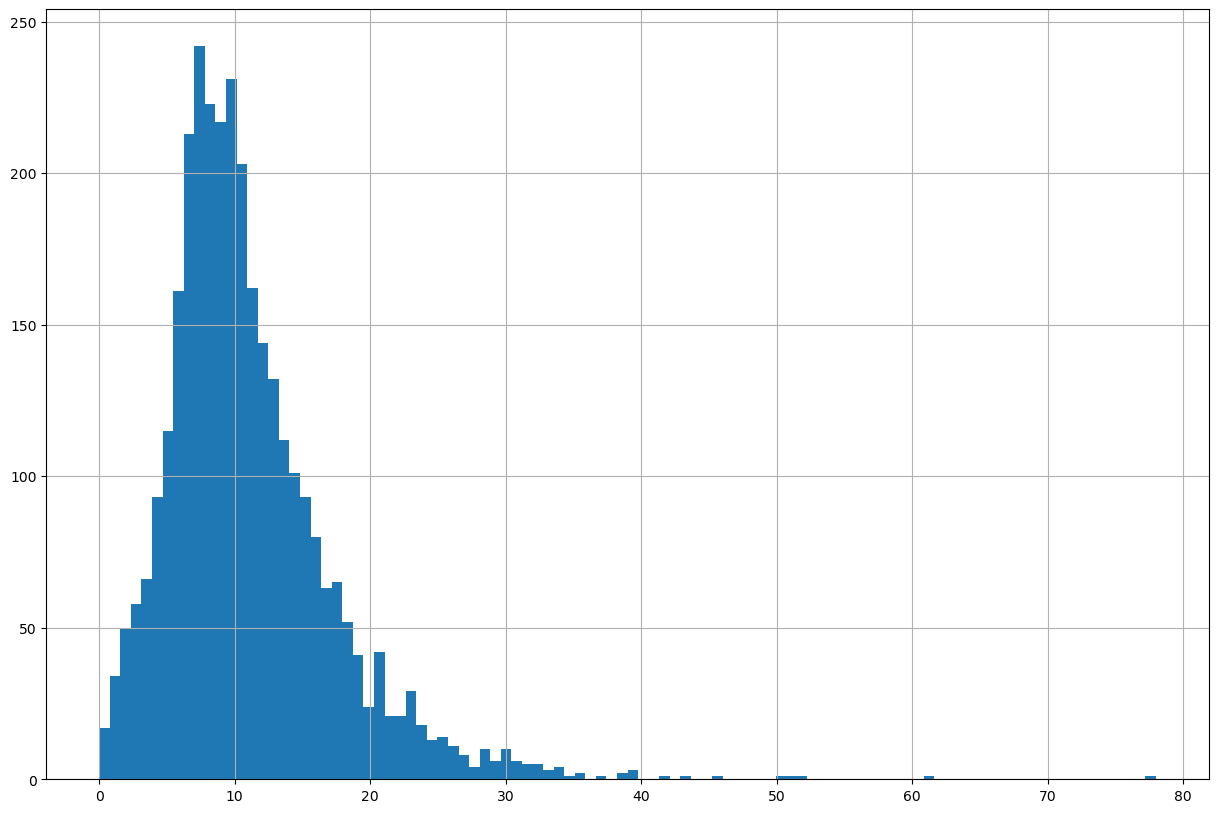

In [13]:
data_gas['Газ 1'].hist(bins=100, figsize=(15,10));

#### Промежуточный вывод данных о продувке сплава газом

Данный датасет состоит всего из одного признака Газ1( не считая key). Нет ни пропусков, ни дуликатов. Корреляция не информативна между признаками, выбросы имеются в небольшом кол-ве, тип данных верный.

### Результаты измерения температуры

In [14]:
df_info(data_temp)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

Внешний вид таблицы :


,key,Время замера,Температура
3560,638,2019-05-27 21:28:02,1600.0
17280,3089,2019-09-01 11:21:00,NaN
14539,2602,2019-08-14 11:35:30,NaN
1640,293,2019-05-14 20:43:25,1587.0
8311,1486,2019-06-28 08:44:10,1585.0


Столбцы таблицы: ['key', 'Время замера', 'Температура']
 

Общее количество уникальных значений столбцов ['key', 'Время замера', 'Температура']:

key              3216
Время замера    18092
Температура       172
dtype: int64 

Количество пропущенных значений столбцов ['key', 'Время замера', 'Температура']:

key                0
Время замера       0
Температура     3427
dtype: int64


Соотношение дубликатов столбца key ко всем строкам:	 4.544781532510597e-05


Соотношение дубликатов столбца Время замера ко всем строкам:	 0.0


Соотношение дубликатов столбца Температура ко всем строкам:	 5.474451484341047e-05

Соотношение явных дубликтов ко всем строкам: 0.0


Таблица корреляций значений столбцов ['key', 'Время замера', 'Температура']:

                 key  Температура
key          1.00000     -0.05627
Температура -0.05627      1.00000 
 

Таблица распределений значений столбцов ['key', 'Время замера', 'Температура']:

                key   Температура
count  18092.000000  14665.000000


<AxesSubplot:>

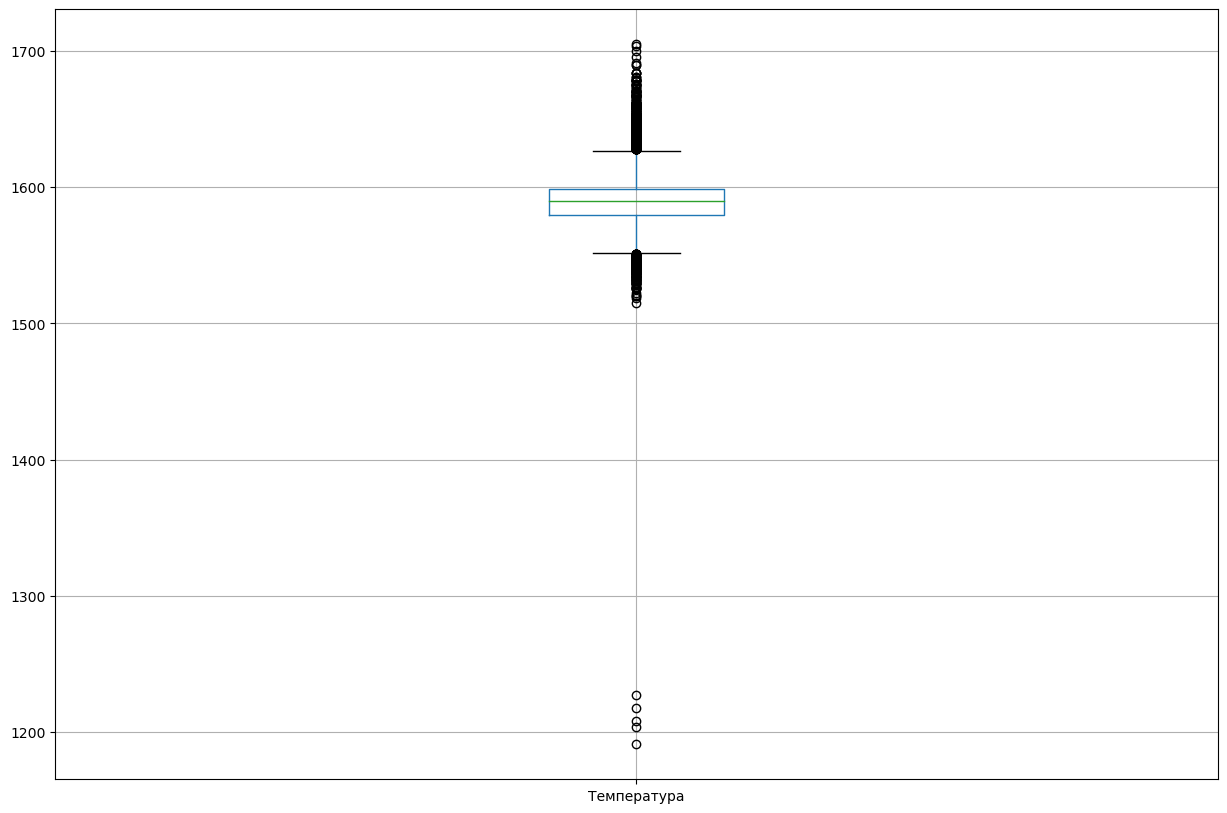

In [15]:
data_temp_1=data_temp.drop('key', axis=1)
data_temp_1.boxplot(figsize=(15,10))

#### Промежуточный вывод данных о замерах температуры

Данные состоят из 2 признаков( температура и время замера) и уникального кода. Пропуски присутствуют только в столбце Температура, дубликатов нет, тип данный на времени замера стоит не верный( присвоен тип object). По диаграмме размаха можно заметить выбросы в виде заниженной температуры ( меньше 1500 градусов)

### Данные о проволочных материалах (объём)

In [16]:
df_info(data_wire)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Внешний вид таблицы :


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1616,1696,90.136803,10.133759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,543,120.135598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2890,3049,17.035200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2981,3140,49.096321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,260,104.220474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Столбцы таблицы: ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
 

Общее количество уникальных значений столбцов ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']:

key       3081
Wire 1    2251
Wire 2     713
Wire 3      56
Wire 4      14
Wire 5       1
Wire 6      69
Wire 7      10
Wire 8      13
Wire 9      25
dtype: int64 

Количество пропущенных значений столбцов ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Соотношение дубликатов столбца key ко всем строкам:	 0.0


Соотношение дубликатов столбца Wire 1 ко всем строкам:	 8.733154308937282e-05


Соотношение дубликатов столбца Wire 2 ко всем строкам:	 0.00024935315137822133


Соотношение дубликатов столбца Wire 3 ко всем

<AxesSubplot:>

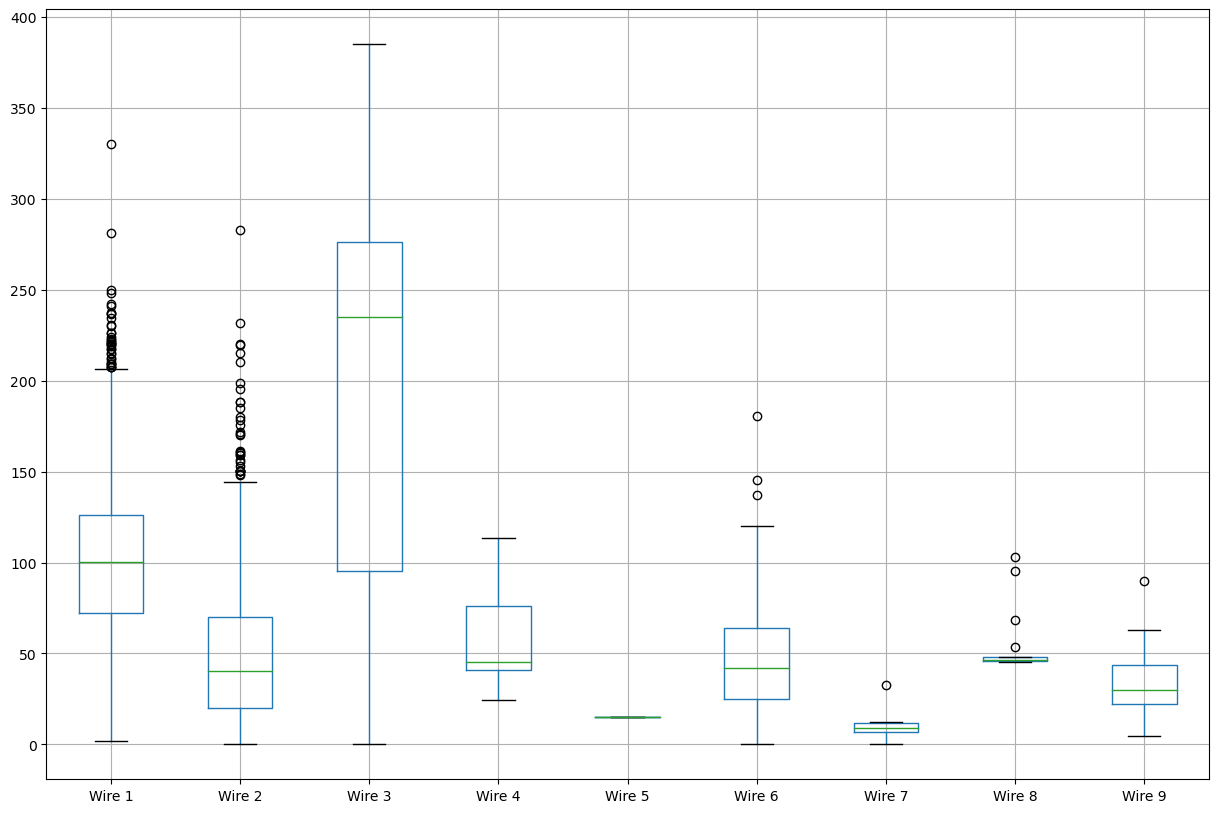

In [17]:
data_wire_1=data_wire.drop('key', axis=1)
data_wire_1.boxplot(figsize=(15,10))

#### Промежуточный вывод данных об объеме проволочных материалах

В данных представлены значения объема проволочных материалов(9 различных веществ) и их уникальный код. Дубликатов нет, а пропуски напоминают пропуски в объемах сыпучих веществ( возможно, придется отследить соответствия значений) Корреляция между признаками среднеположительная/отрицательная, может быть искажена. Тип данных верный.

### Данные о проволочных материалах (время)

In [18]:
df_info(data_wire_time)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Внешний вид таблицы :


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3075,3236,2019-09-06 10:57:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1624,1704,2019-07-06 00:07:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1288,1357,2019-06-23 17:50:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2152,2262,2019-08-01 21:27:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1634,1714,2019-07-06 06:49:27,2019-07-06 06:41:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Столбцы таблицы: ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
 

Общее количество уникальных значений столбцов ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']:

key       3081
Wire 1    3055
Wire 2    1079
Wire 3      63
Wire 4      14
Wire 5       1
Wire 6      73
Wire 7      11
Wire 8      19
Wire 9      29
dtype: int64 

Количество пропущенных значений столбцов ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Соотношение дубликатов столбца key ко всем строкам:	 0.0


Соотношение дубликатов столбца Wire 1 ко всем строкам:	 2.6336412270619065e-06


Соотношение дубликатов столбца Wire 2 ко всем строкам:	 0.000210796643814035


Соотношение дубликатов столбца Wire 3 ко всем 

#### Промежуточный вывод данных об времени загрузки проволочных материалов

Данные соответсвуют данным выше, те же признаки( код, время загрузки вещества). Тип данных неверный( нужен datetime, как и в предыдущих таблицах). Дубликаты отсутствуют, пропуски схоже с пропусками объемов. Корреляции нет между числовыми признаками( всего один стобец key).

### Общий вывод по исследованию данных

После тщательного посмотра предоставленных данных, можно составить план действий для дальнейшей работы, а именно предобработка данных.

    1. Изменить тип данных во временых значениях на datetime
    2. Понять природу пропусков. Если их можно заполнить, то решить чем именно.
    3. Удалить выбросы
    4. Удалить неинформативные признаки, если такие имеются.
    5. Объединить таблицы по уникальному коду для дальнейшего обучения модели.
    
Далее составим предварительный план выбора модели и ее обучения:

    1.Разбивка данных на выборки
    2.Подбор лучших гиперпараметров в моделях
    3.Выбор модели по лучшей метрики
    4.Обучение лучшей модели
    5.Состаление выводов
    

План может меняться по мере прохождения этапов данного проекта.

## Предобработка данных

Перейдем к предобработке наших данных. Как мы уже выяснили, нужно исправить неверные типы данных, избавиться от аномалий и заполнить пропуски, если в этом есть необходимость.

Начнем со стандартного, приведем название признаков к нижнему регистру и преобразуем все к формату РЕР-8

In [19]:
data_arc.columns = (data_arc.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.lower())
data_bulk.columns = (data_bulk.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.lower())
data_bulk_time.columns = (data_bulk_time.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.lower())
data_gas.columns = (data_gas.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.lower())
data_temp.columns = (data_temp.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.lower())
data_wire.columns = (data_wire.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.lower())
data_wire_time.columns = (data_wire_time.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.lower())

Теперь начнем обработку данных по каждому датафрейму

###  Данные об электродах

In [20]:
# Создадим функцию по переименованию
def column_renamer(df, old_col_list, new_col_list):
     
    dict_to_rename = {}
    for i in zip(old_col_list, new_col_list):
        dict_to_rename[i[0]] = i[1]
    df.rename(columns=dict_to_rename, inplace = True)
    

In [21]:
# Приведем к нужному типу данных временные признаки
data_arc['начало_нагрева_дугой'] = pd.to_datetime(data_arc['начало_нагрева_дугой'], format="%Y-%m-%d %H:%M:%S")
data_arc['конец_нагрева_дугой'] = pd.to_datetime(data_arc['конец_нагрева_дугой'], format="%Y-%m-%d %H:%M:%S")

# переименуем стобцы
arc_old_col_list = ['начало_нагрева_дугой', 'конец_нагрева_дугой', 'активная_мощность', 'реактивная_мощность']
arc_new_col_list = ['arc_start_time', 'arc_end_time', 'arc_active_power', 'arc_reactive_power']

column_renamer(df=data_arc, old_col_list=arc_old_col_list, new_col_list=arc_new_col_list)

# Проверим наши преобразования
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   arc_start_time      14876 non-null  datetime64[ns]
 2   arc_end_time        14876 non-null  datetime64[ns]
 3   arc_active_power    14876 non-null  float64       
 4   arc_reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [22]:
data_arc.describe()

,key,arc_active_power,arc_reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [23]:
# Избавимся от аномалий
data_arc = data_arc[data_arc['arc_reactive_power'] > 0]

# Проверяем
data_arc.describe()

,key,arc_active_power,arc_reactive_power
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


Добавим дополнительные признаки: Полная мощность, Потребляемая мощность, Время нагрева


Как будем расчитывать Полную и Потребляемую мощности. Исходя из формулы, Полная мощность расчитывается:

$$ S= \sqrt{P^2+Q^2} $$

P — активная , Q — реактивная

Потребляемая мощность расчитывается по формуле:
$$ Sпотр = Sполн * t $$
t- время нагрева

In [24]:
# Добавим признак Время нагрева в секундах
data_arc['arc_full_time'] = data_arc['arc_end_time'] - data_arc['arc_start_time']
data_arc['arc_full_time_s'] = data_arc['arc_full_time'].apply(lambda x:x.seconds)


# Добавим Полная мощность
data_arc['arc_full_power'] = np.sqrt(data_arc['arc_active_power'] ** 2 + data_arc['arc_reactive_power'] ** 2)

data_arc.head(5)

,key,arc_start_time,arc_end_time,arc_active_power,arc_reactive_power,arc_full_time,arc_full_time_s,arc_full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48,228,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05,185,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52,172,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05,365,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28,148,1.079934


In [25]:
# Сгруппируем таблицу по 1 ключу.
data_arc_1 = data_arc.groupby("key").agg({'arc_start_time':'first',
                                        'arc_end_time':'last',
                                        "arc_active_power":"mean",
                                        "arc_reactive_power":"mean",
                                        "arc_full_time":"sum",
                                          'arc_full_time_s': 'sum',
                                        "arc_full_power":"mean"}).reset_index()
# Добавим признак Потребляемая мощность
data_arc_1['arc_cons_power'] = data_arc_1['arc_full_power']*data_arc_1['arc_full_time_s']

display(data_arc_1)

,key,arc_start_time,arc_end_time,arc_active_power,arc_reactive_power,arc_full_time,arc_full_time_s,arc_full_power,arc_cons_power
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,0 days 00:18:18,1098,0.743747,816.634387
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,0 days 00:13:31,811,0.647087,524.787700
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,0 days 00:10:55,655,1.003845,657.518274
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,0 days 00:12:21,741,0.850010,629.857043
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,0 days 00:14:29,869,0.704245,611.988831
...,...,...,...,...,...,...,...,...,...
3209,3237,2019-09-06 11:31:25,2019-09-06 11:53:55,0.508374,0.405083,0 days 00:15:09,909,0.650131,590.969499
3210,3238,2019-09-06 12:16:25,2019-09-06 12:31:35,0.458274,0.346034,0 days 00:09:06,546,0.574646,313.756580
3211,3239,2019-09-06 14:17:00,2019-09-06 15:05:50,0.606001,0.442693,0 days 00:20:16,1216,0.751810,914.200902
3212,3240,2019-09-06 15:25:31,2019-09-06 16:24:15,0.663536,0.474710,0 days 00:13:59,839,0.816584,685.114042


In [26]:
data_arc_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   key                 3214 non-null   int64          
 1   arc_start_time      3214 non-null   datetime64[ns] 
 2   arc_end_time        3214 non-null   datetime64[ns] 
 3   arc_active_power    3214 non-null   float64        
 4   arc_reactive_power  3214 non-null   float64        
 5   arc_full_time       3214 non-null   timedelta64[ns]
 6   arc_full_time_s     3214 non-null   int64          
 7   arc_full_power      3214 non-null   float64        
 8   arc_cons_power      3214 non-null   float64        
dtypes: datetime64[ns](2), float64(4), int64(2), timedelta64[ns](1)
memory usage: 226.1 KB


<AxesSubplot:>

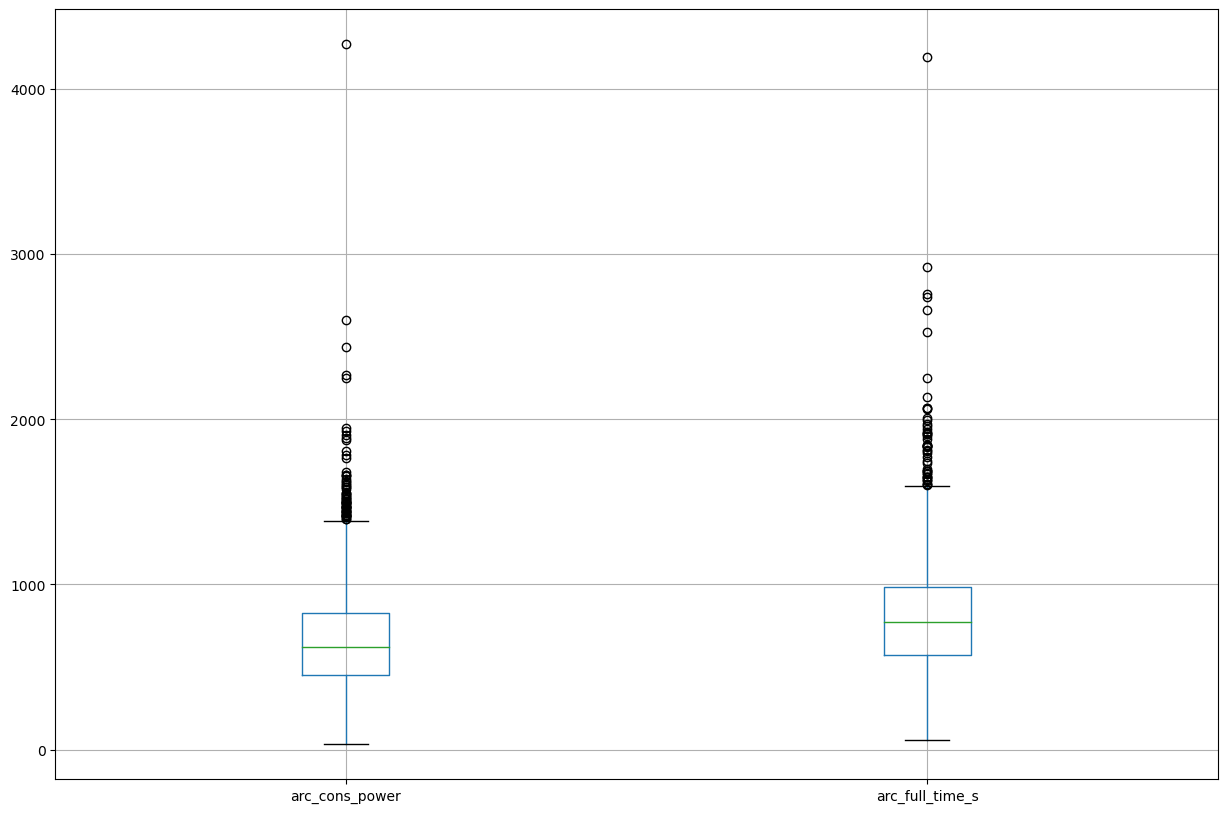

In [27]:
# Попробуем визуализировать наши новые признаки
data_arc_2=data_arc_1.drop('key' , axis=1)
data_arc_2[['arc_cons_power', 'arc_full_time_s']]  .boxplot(figsize=(15,10))

Судя по диаграмме распределения, время нагрева практически соответствует потраченой мощности, как и должно было выйти. Также мы таблицу привели к виду 1 ключ -1 итерация. Все возможные преобразования на данном этапе мы сделали. Переходим к следующей таблице.

### Данные о подаче сыпучих и проволочных материалов (объём)

In [28]:
# Просмотрим данные таблиц еще раз
data_bulk.info()
print('====== '*5)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
====== ====== ====== ====== ====== 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  

 В данных таблицах мы заменим пропуски на 0. Удалять их нельзя, так как каждый пропуск означает, что данное вещ-во не добавляли на той или иной итерации.

In [29]:
# Заменим пропуски нулями
data_bulk.fillna(value=0, inplace=True)
data_wire.fillna(value=0, inplace=True)

data_bulk.info()
print('====== '*5)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
====== ====== ====== ====== ====== 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  

### Данные о подаче сыпучих и проволочных материалов (время)

Аналогичная ситуация с таблицами сыпучих и проволочных материалов(время).

In [30]:
# Просмотрим данные таблиц еще раз
data_bulk_time.info()
print('====== '*5)
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
====== ====== ====== ====== ====== 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dt

In [31]:
# Заменим пропуски нулями
data_bulk_time.fillna(value=0, inplace=True)
data_wire_time.fillna(value=0, inplace=True)


data_bulk_time.info()
print('====== '*5)
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   3129 non-null   object
 2   bulk_2   3129 non-null   object
 3   bulk_3   3129 non-null   object
 4   bulk_4   3129 non-null   object
 5   bulk_5   3129 non-null   object
 6   bulk_6   3129 non-null   object
 7   bulk_7   3129 non-null   object
 8   bulk_8   3129 non-null   object
 9   bulk_9   3129 non-null   object
 10  bulk_10  3129 non-null   object
 11  bulk_11  3129 non-null   object
 12  bulk_12  3129 non-null   object
 13  bulk_13  3129 non-null   object
 14  bulk_14  3129 non-null   object
 15  bulk_15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
====== ====== ====== ====== ====== 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dt

По идее, можно объединить эти таблицы с таблицами объема. Но смысла в этом большого не будет, так как нам важна именно температура и кол-во добавок. Возможно, в ходе нашей работы мы поймем, что совершили ошибку, и объединим так же время добавления реагентов, но пока оставим как есть.

### Результаты измерения температуры

In [32]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   время_замера  18092 non-null  object 
 2   температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [33]:
temp_old_col_list = ['время_замера', 'температура']
temp_new_col_list = ['temp_start_time', 'temperature']

column_renamer(df=data_temp, old_col_list=temp_old_col_list, new_col_list=temp_new_col_list)


<AxesSubplot:>

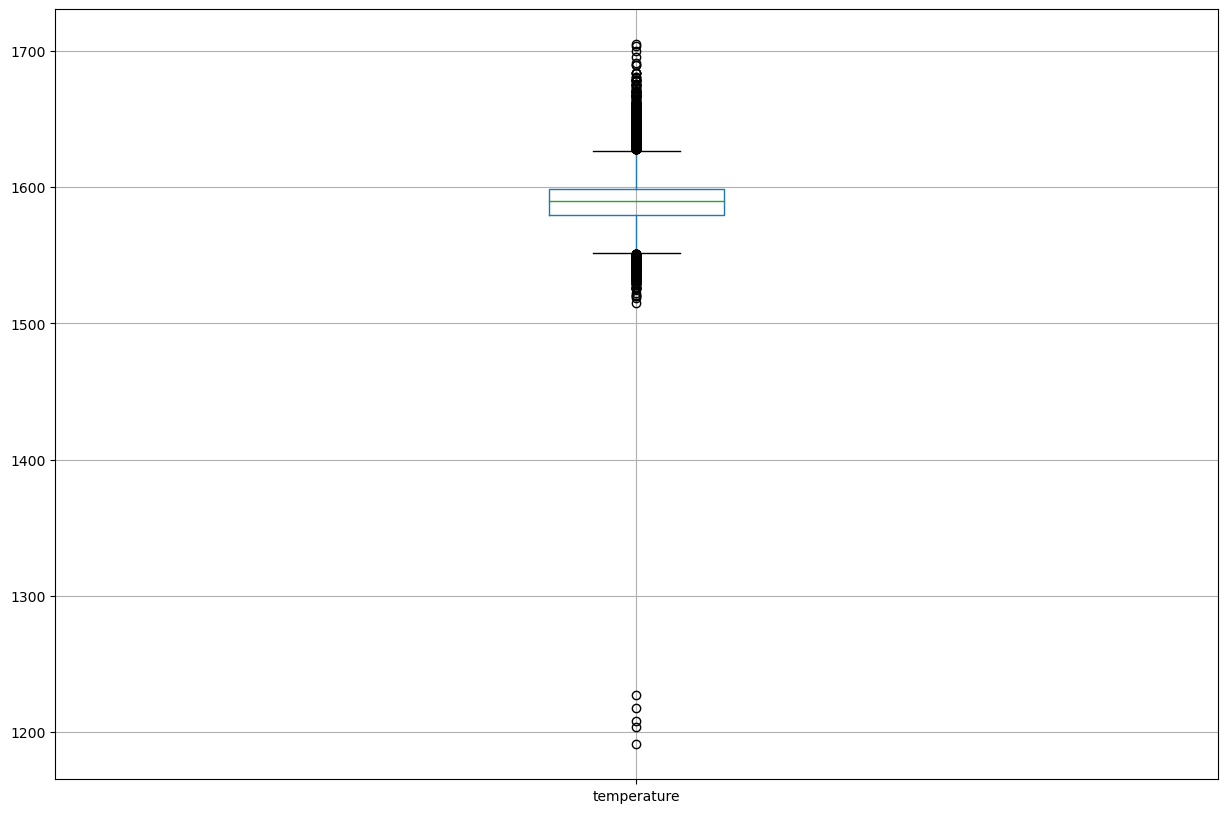

In [34]:
# Посмотрим еще раз на диаграмму размаха
data_temp_1=data_temp.drop('key', axis=1)
data_temp_1.boxplot(figsize=(15,10))

По данным заказчика, температура не может быть ниже 1500 градусов, значит удалим выбросы. А также приведем признак Время замера к нужному типу и удалим пропуски у целевого признака Температура

In [35]:
# Приведем данные к нужному типу
data_temp['temp_start_time']=pd.to_datetime(data_temp['temp_start_time'])

# Проверяем
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              18092 non-null  int64         
 1   temp_start_time  18092 non-null  datetime64[ns]
 2   temperature      14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [36]:
# Посмотрим, у каких ключей аномальная температура
data_temp_key=data_temp.copy()
data_temp_key = data_temp_key[data_temp_key['temperature'] <= 1500]
display(data_temp_key)

,key,temp_start_time,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [37]:
# Посмотрим,где температура не менялась
keys_with_nulls = data_temp[data_temp['temperature'].isna()]['key'].unique().tolist()
keys_with_nulls[:5]

[2500, 2501, 2502, 2503, 2504]

Судя по нашим результатом, партии после 2500 ключа не меняются, значит их можно смело удалять

In [38]:
# Удалим эти ключи
data_temp_final = data_temp.query('key not in (867, 1214, 1619, 2052, 2561) and key < 2500')

data_temp_final.info()
display(data_temp_final.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              13905 non-null  int64         
 1   temp_start_time  13905 non-null  datetime64[ns]
 2   temperature      13905 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


,key,temp_start_time,temperature
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0
13925,2499,2019-08-10 13:58:58,1603.0


<AxesSubplot:>

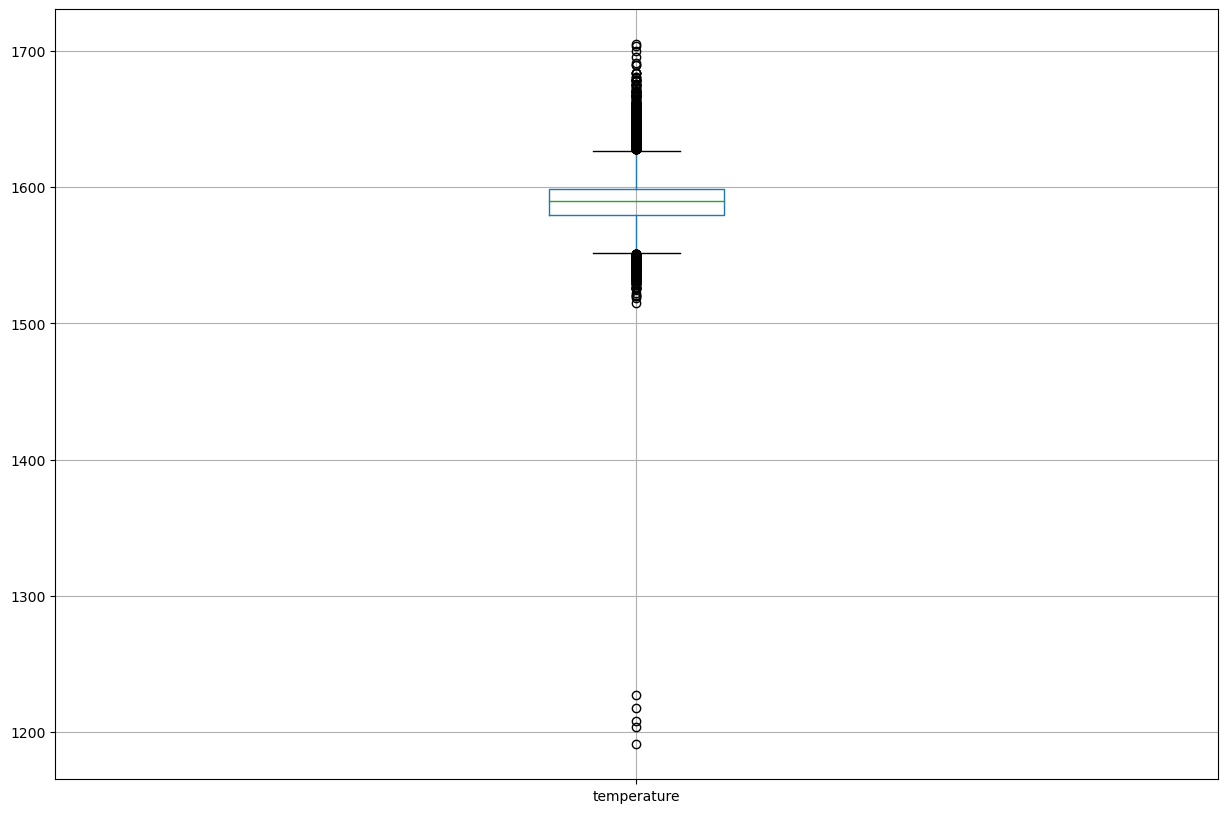

In [39]:
data_temp_2=data_temp.drop('key', axis=1)
data_temp_2.boxplot(figsize=(15,10)) 

Температура-это наш целевой признак. Оставим для обучения модели только начальную температуру замера и конечную, так как промежуточные результаты будут мешать предсказывать результат. Таким образом, у нашего ключа будет также 1 итерация.

In [40]:
# Найдем первую и  последнюю температуру
data_temp_info = (data_temp_final.pivot_table(index='key', aggfunc=['first','last'])).reset_index()
data_temp_info.columns=['key','first_time','temp_first','time_last','temp_last']

# Добавим время измерения
data_temp_info['temp_full_time'] = data_temp_info['time_last'] - data_temp_info['first_time']
data_temp_info['temp_full_time'] = data_temp_info['temp_full_time'].apply(lambda x:x.seconds)
display(data_temp_info.head())

,key,first_time,temp_first,time_last,temp_last,temp_full_time
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536


In [41]:
data_temp_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             2473 non-null   int64         
 1   first_time      2473 non-null   datetime64[ns]
 2   temp_first      2473 non-null   float64       
 3   time_last       2473 non-null   datetime64[ns]
 4   temp_last       2473 non-null   float64       
 5   temp_full_time  2473 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 116.0 KB


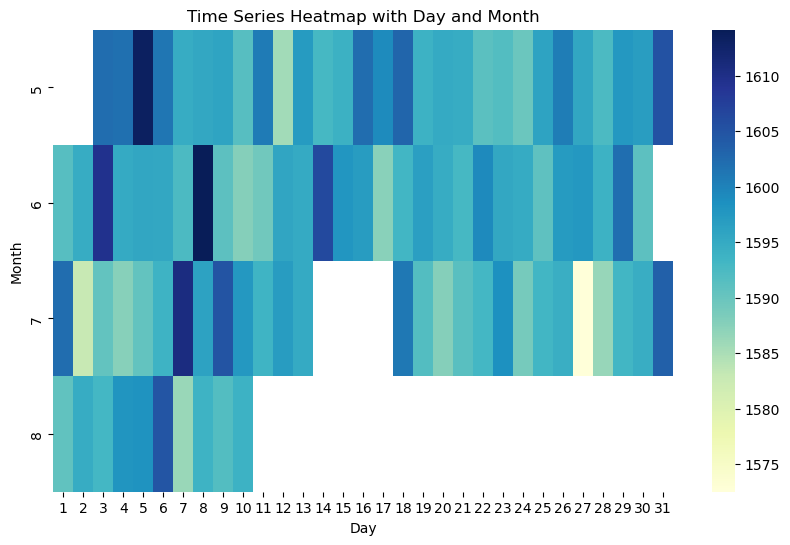

In [42]:
# Посмотрим, как зависит наша температура от временных промежутков
data_temp_g = data_temp_info.copy()
data_temp_g['day'] = data_temp_g['time_last'].dt.day
data_temp_g['month'] = data_temp_g['time_last'].dt.month

pivot_data = data_temp_g.pivot_table(index='month',
                                     columns='day',
                                     values='temp_last')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, cmap='YlGnBu')
plt.xlabel('Day')
plt.ylabel('Month')
plt.title('Time Series Heatmap with Day and Month')
plt.show()

На графике видно явные простои в несколько дней. Также видно, что в зависимости от добавки, температура меняется, к концу периода, температура почти на минимуму.
Таблицу привели в нужный вид, переходим к следующему этапу, а именно объединение данных в итоговую таблицу.


###  Объединение таблиц

Будем создавать нашу итоговую таблицу из наших предоставленных данных. Не возьмем, как уже обговорили, данные об времени добавления сыпучих и проволочных веществ.

In [43]:
# Объединим все наши таблицы в одну.
df_merge=data_arc_1.merge(data_bulk, how = 'inner', on = 'key' )\
    .merge(data_gas, how='inner', on = 'key')\
    .merge(data_temp_info, how='inner', on = 'key')\
    .merge(data_wire, how='inner', on = 'key')

df_merge

,key,arc_start_time,arc_end_time,arc_active_power,arc_reactive_power,arc_full_time,arc_full_time_s,arc_full_power,arc_cons_power,bulk_1,...,temp_full_time,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.428564,0 days 00:18:18,1098,0.743747,816.634387,0.0,...,1714,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.363339,0 days 00:13:31,811,0.647087,524.787700,0.0,...,1265,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,0.587491,0 days 00:10:55,655,1.003845,657.518274,0.0,...,1753,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.514248,0 days 00:12:21,741,0.850010,629.857043,0.0,...,1220,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.421998,0 days 00:14:29,869,0.704245,611.988831,0.0,...,1536,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,2019-08-10 11:27:57,2019-08-10 11:48:05,0.792033,0.552734,0 days 00:12:03,723,0.967180,699.271318,0.0,...,1380,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,2019-08-10 11:56:58,2019-08-10 12:23:07,0.695820,0.478672,0 days 00:15:40,940,0.845053,794.349480,0.0,...,1705,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,2019-08-10 12:37:36,2019-08-10 12:51:20,1.201746,0.817364,0 days 00:09:29,569,1.453639,827.120721,0.0,...,962,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,2019-08-10 12:58:21,2019-08-10 13:20:59,0.640462,0.447964,0 days 00:12:30,750,0.781983,586.487560,0.0,...,1520,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   key                 2325 non-null   int64          
 1   arc_start_time      2325 non-null   datetime64[ns] 
 2   arc_end_time        2325 non-null   datetime64[ns] 
 3   arc_active_power    2325 non-null   float64        
 4   arc_reactive_power  2325 non-null   float64        
 5   arc_full_time       2325 non-null   timedelta64[ns]
 6   arc_full_time_s     2325 non-null   int64          
 7   arc_full_power      2325 non-null   float64        
 8   arc_cons_power      2325 non-null   float64        
 9   bulk_1              2325 non-null   float64        
 10  bulk_2              2325 non-null   float64        
 11  bulk_3              2325 non-null   float64        
 12  bulk_4              2325 non-null   float64        
 13  bulk_5              2325 non-null

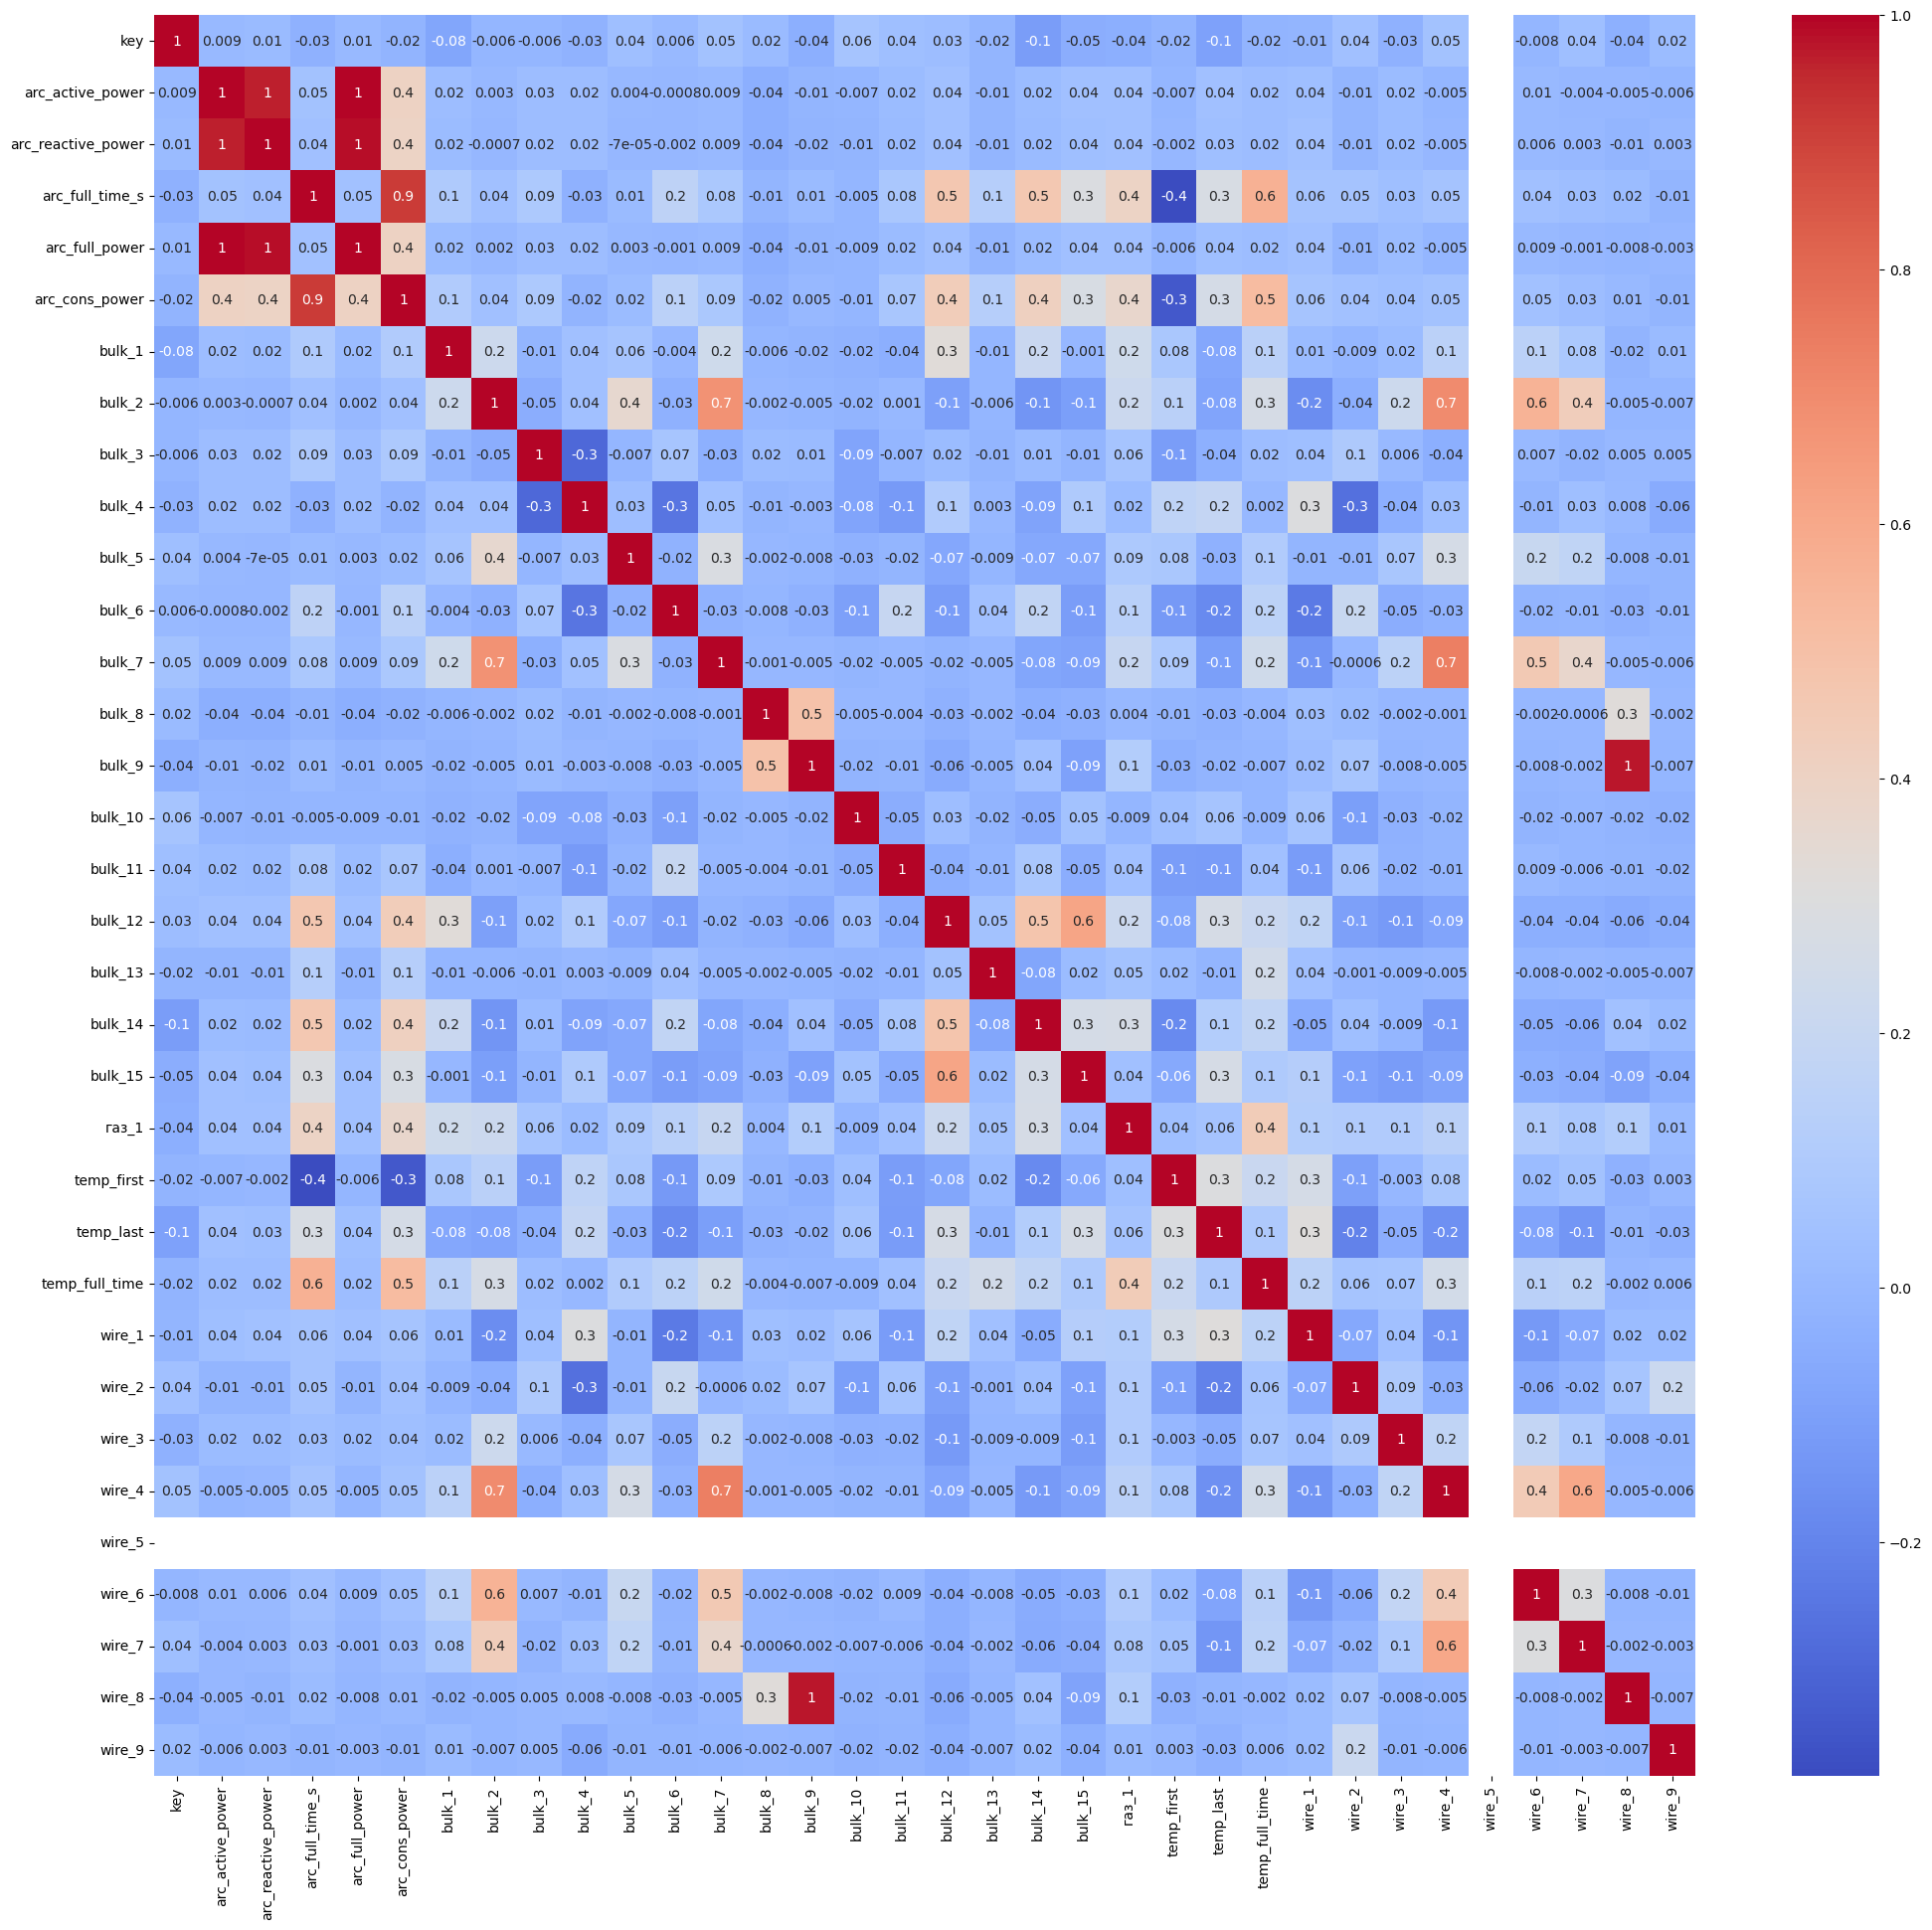

In [45]:
# Посмотрим на корреляцию нашей таблицы
corr = df_merge.corr()
plt.figure(figsize= (25, 23))
sns.heatmap(corr,cmap= 'coolwarm', fmt=".1g", annot=True)
plt.show()

Мы наблюдаем наличие признаков с высокой сколлерированностью. Например, чтобы избавиться от мультиколлинеарности, удалим признаки Реактивная мощность, так как у нас имеется признак Полная мощность, также удалим временные признаки, кроме признаков в секундах, и Bulk_9, Bulk_7, Bulk_2, Wire_5

In [46]:
# Удалим ненужные признаки
df_merge=df_merge.drop(columns=['arc_reactive_power', 'arc_start_time', 'arc_end_time', 'arc_full_time',
                                'first_time', 'time_last','bulk_2','bulk_7','bulk_9', 'wire_5'])

df_merge.info()м

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2325 non-null   int64  
 1   arc_active_power  2325 non-null   float64
 2   arc_full_time_s   2325 non-null   int64  
 3   arc_full_power    2325 non-null   float64
 4   arc_cons_power    2325 non-null   float64
 5   bulk_1            2325 non-null   float64
 6   bulk_3            2325 non-null   float64
 7   bulk_4            2325 non-null   float64
 8   bulk_5            2325 non-null   float64
 9   bulk_6            2325 non-null   float64
 10  bulk_8            2325 non-null   float64
 11  bulk_10           2325 non-null   float64
 12  bulk_11           2325 non-null   float64
 13  bulk_12           2325 non-null   float64
 14  bulk_13           2325 non-null   float64
 15  bulk_14           2325 non-null   float64
 16  bulk_15           2325 non-null   float64


## Выбор модели


Так как перед нами стоит задача регрессии, то и модели мы выберем для регрессии. Из простых возьмем по классике Случайный лес, Дерево решений и линейную регрессию. Из сложных моделей возьмем CatBoost и GBMLight с использованием кросс-валидации RandomizedSearchCV.

In [47]:
# Разделим данные на выборки
RANDOM_STATE=10823


features=df_merge.drop('temp_last', axis=1)
target=df_merge['temp_last']

# Разделим на тестовую и тренировочные выборки ( тестовую возьмем 25%)
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state = RANDOM_STATE
                                                                            )


print('Размер тренировочной выборки:', features_train.shape[0])
print('Размер тестовой выборки:', features_test.shape[0])

Размер тренировочной выборки: 1743
Размер тестовой выборки: 582


In [48]:
# Создадим функцию, которая будет обучать модель на лучших гиперпараметрах
def grid(model, params):
    grid = RandomizedSearchCV(model,
    param_distributions=params, random_state=RANDOM_STATE,
    scoring='neg_mean_absolute_error',
    n_jobs=-1, cv=5)
    grid.fit(features_train, target_train)
    best_score_mae = round(grid.best_score_*-1, 3)

    grid = RandomizedSearchCV(model,
    param_distributions=params,
    scoring='r2',
    n_jobs=-1, cv=5)
    grid.fit(features_train, target_train)
    best_score_r2 = round(grid.best_score_, 3)

    print('MAE на обучающей выборке:', best_score_mae)
    print('R2 на обучающей выборке:', best_score_r2)
    print('----------------------')
    print('Oптимальные параметры:\n', grid.best_params_)
    return best_score_mae, best_score_r2

In [49]:
# Проведем масштабирование признаков
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [50]:
%%time
# Начнем с модели LinearRegression
params =  {}

mae_lr, r2_lr = grid(LinearRegression(), params)


MAE на обучающей выборке: 6.053
R2 на обучающей выборке: 0.398
----------------------
Oптимальные параметры:
 {}
Wall time: 4.49 s


In [51]:
%%time
# Теперь Random Forest
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}

mae_rf, r2_rf = grid(RandomForestRegressor(), params)


MAE на обучающей выборке: 6.148
R2 на обучающей выборке: 0.421
----------------------
Oптимальные параметры:
 {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_depth': 14}
Wall time: 10.3 s


In [52]:
%%time
# Перейдем Decision Tree Regressor
params =  {'max_depth': range (1,13, 2),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}

mae_dt, r2_dt = grid(DecisionTreeRegressor(), params)



MAE на обучающей выборке: 7.043
R2 на обучающей выборке: 0.202
----------------------
Oптимальные параметры:
 {'min_samples_split': 8, 'min_samples_leaf': 7, 'max_depth': 5}
Wall time: 261 ms


In [53]:
%%time
# Обучим модель CatBoost
params =  {'depth': range (4,10)}

mae_cb, r2_cb = grid(CatBoostRegressor(verbose=False), params)


MAE на обучающей выборке: 5.734
R2 на обучающей выборке: 0.513
----------------------
Oптимальные параметры:
 {'depth': 4}
Wall time: 5min 40s


In [54]:
%%time
# LGBMRegressor
params =  {'max_depth': range (4,15),
          'n_estimators': range(10, 155, 15) }

mae_lgbm, r2_lgbm = grid(LGBMRegressor(), params)


MAE на обучающей выборке: 5.865
R2 на обучающей выборке: 0.477
----------------------
Oптимальные параметры:
 {'n_estimators': 70, 'max_depth': 6}
Wall time: 4.99 s


In [55]:
%%time
# Проверим константную модель DummyRegressor
params =  {}

mae_d, r2_d = grid(DummyRegressor(strategy='median'), params)

MAE на обучающей выборке: 8.049
R2 на обучающей выборке: -0.003
----------------------
Oптимальные параметры:
 {}
Wall time: 43.5 ms


In [56]:
# Посмотрим на наши результаты
d = {'LinearRegression': (mae_lr, r2_lr),
     'Random Forest':(mae_rf, r2_rf),
     'Decision Tree Regressor':(mae_dt, r2_dt),
     'CatBoost':(mae_cb, r2_cb),
     'LGBMRegressor':(mae_lgbm, r2_lgbm),
     'Dummy': (mae_d, r2_d)
     }
headers=['Имя','MAE','R2']
print(tabulate([(i,) +d[i] for i in d], headers = headers, tablefmt="github"))



| Имя                     |   MAE |     R2 |
|-------------------------|-------|--------|
| LinearRegression        | 6.053 |  0.398 |
| Random Forest           | 6.148 |  0.421 |
| Decision Tree Regressor | 7.043 |  0.202 |
| CatBoost                | 5.734 |  0.513 |
| LGBMRegressor           | 5.865 |  0.477 |
| Dummy                   | 8.049 | -0.003 |


По нашим результатам видно, что лучшей моделей является CatBoost, также можель прошла проверку, метрика лучше чем на константной моделе. Проведем тестирование.

In [57]:
# Обучаем модель CatBoost с лучшими метриками
best_model_cb = CatBoostRegressor(loss_function = 'MAE', verbose = False, random_state=RANDOM_STATE, depth=4)

best_model_cb.fit(features_train, target_train)
best_model_predictions_cb = best_model_cb.predict(features_test)

# Вычисляем метрики для лучшей модели
best_model_cb_mae = mean_absolute_error(target_test, best_model_predictions_cb)
best_model_cb_r2 = r2_score(target_test, best_model_predictions_cb)

In [58]:
print('МАЕ CatBoost:', best_model_cb_mae, 'R2 CatBoost:', best_model_cb_r2)

МАЕ CatBoost: 5.882777831993778 R2 CatBoost: 0.48005184452210636


Разница между метриками на тренировойной и тестовой выборках небольшая. Мы прошли наш порог по значению МАЕ<=6.5 и наши результаты: МАЕ CatBoost: 5.88, однако, значение метрики R2 оставляет желать лучшего.

Permutation explainer: 583it [00:50,  9.81it/s]                                                                        


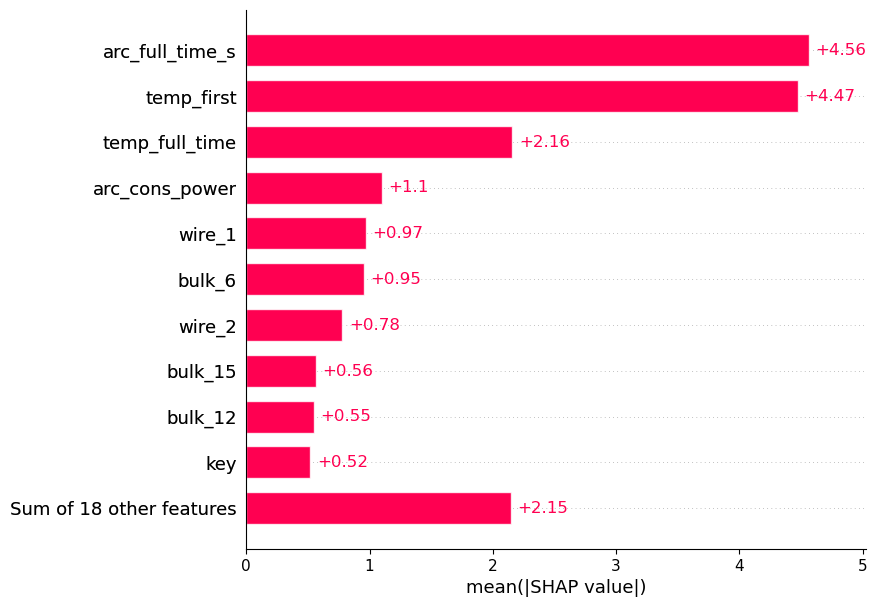

In [59]:
# Посмотрим на важность признаков
def explain_features(best_models, features_train, features_test):
    explainer = shap.explainers.Permutation(best_models.predict, features_train)
    shap_values = explainer(features_test)

    shap.plots.bar(shap_values, max_display=11)

    plt.show()


explain_features(best_model_cb, 
                 pd.DataFrame(features_train, columns=features.columns), 
                 pd.DataFrame(features_test, columns=features.columns))

Как мы видим, такие признаки как Начальная температура и Время нагрева оказывают сильное  влияние на модели.  Возможно, это связано с тем, что добавленные вещества по разному реагируют, если начальная температура и время всего нагрева будут различаться,что влияет на весь процесс. Также влияет время между добавлением проволочных и связующих веществ, их состав и потребляемая мощность.


Так как у нас стоит задача экономии, то было бы целесообразно расчитать затраты на электроэнергию. Это будет бонусом для клиента.

In [60]:
# Рассчитаем общие затраты за весь период
data_money_total=data_arc_1['arc_cons_power'].sum()* 7.15 # средний тариф по СПб за 1 кВт
data_money_total

15045039.833360603

,arc_cons_power,Price
key,,
1,816.634387,5838.935868
2,524.787700,3752.232055
3,657.518274,4701.255656
4,629.857043,4503.477855
5,611.988831,4375.720140
...,...,...
3237,590.969499,4225.431917
3238,313.756580,2243.359544
3239,914.200902,6536.536452


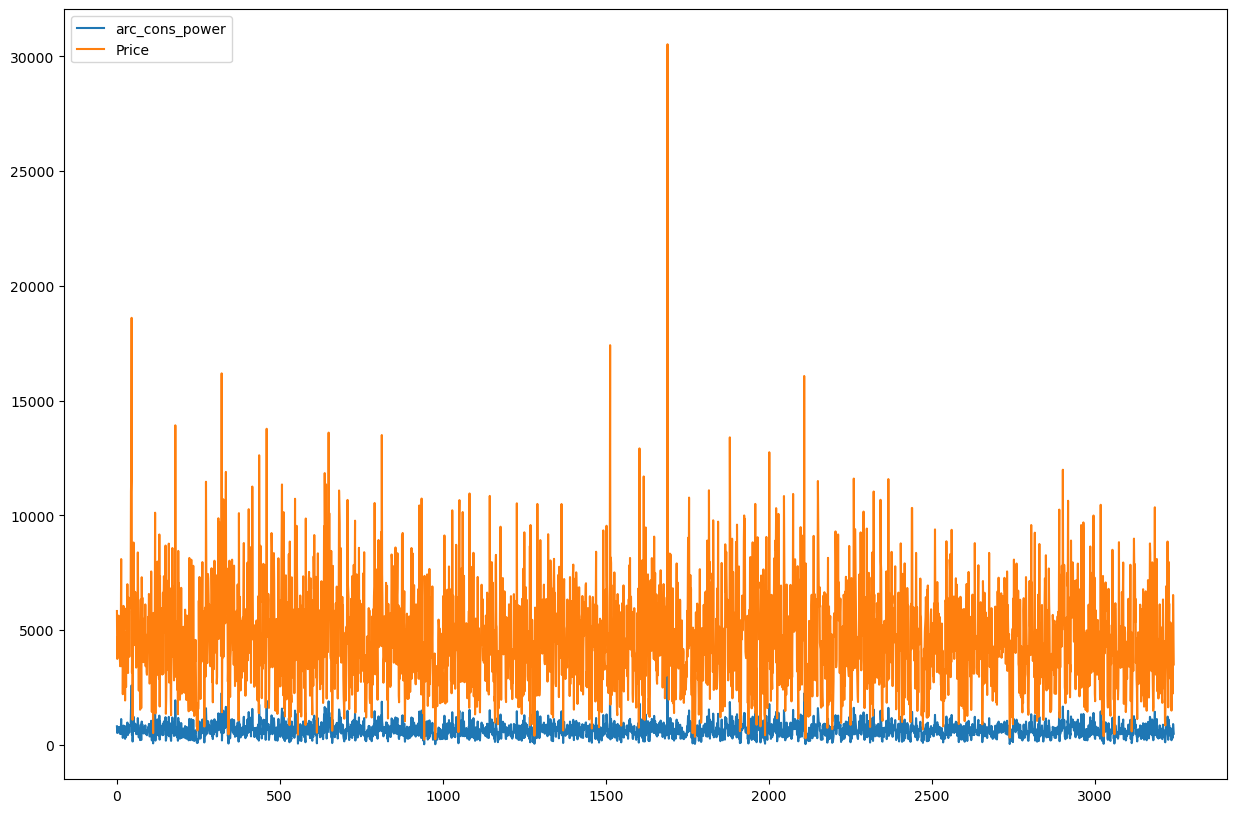

In [61]:
# Создадим таблицу стоимости
data_money=pd.DataFrame(data_arc_1, columns=['key','arc_cons_power']).set_index('key')
data_money['Price'] = data_money['arc_cons_power'] *7.15

display(data_money)

plt.figure(figsize=(15,10))
plt.plot(data_money)
plt.legend(data_money.columns, loc=2)
plt.show()


По этому графику, видно, в какой период, а точнее на каком этапе(key) требуется та или иная мощность, и сколько уходит затрат на нее. Клиент может отследить свои расходы.

# **Выводы**
В рамках настоящего проекта проделана следующая работа:
Наш план действий на 1 этапе был таков:


1. Изменить тип данных во временых значениях на datetime
2. Понять природу пропусков. Если их можно заполнить, то решить чем именно.
3. Удалить выбросы
4. Удалить неинформативные признаки, если такие имеются.
5. Объединить таблицы по уникальному коду для дальнейшего обучения модели.

Далее составим предварительный план выбора модели и ее обучения:

1. Разбивка данных на выборки
2. Подбор лучших гиперпараметров в моделях
3. Выбор модели по лучшей метрики
4. Обучение лучшей модели
5. Состаление выводов
План может меняться по мере прохождения этапов данного проекта.

В ходе нашей работы План не был изменен.


# **Отчет**

## 1. **Введение.**

 Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. В рамках проекта необходимо построить модель, которая предскажет температуру стали и определить наиболее влияющие на температуру параметры. 
     

## 2. **Описание этапа обработки.**

 Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
 Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
 Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## 3. **Цели и задачи проекта.**

 Обеспечение возможности прогнозирования температуры плавления позволит бизнесу иметь возможность управлять процессом выплавки стали, что обеспечит экономию на энергоресурсах и затрачиваемых материалах.


## 4. ** Описание решения (что было сделано).**

 В рамках настоящего проекта проделана следующая работа:
 
 - Проведен предварительный анализ данных на аномалии, пропуски, выбросы.
 - Была проведена предобработка данных. В ходе нее мы избавились от аномалий( температура ниже 1500 градусов), пропусков, и неинформативных признаков( данные после 2500 партии, где нет четкого измерения температуры).Предобработанные данные сгруппированы по партиям и объединены в единую таблицу с общим набором признаков.
 - Проведена проверка на мультиколлинеарность, по ее результатам были исключены  признаки, которые сильно могли повлиять на обучение.
 - На тренировачной выборке обучено пять моделей и выбрана лучшая.
 - На тестовой выборке сделан прогноз при помощи лучшей модели. Необходимый по условиям задания порог МАЕ < 6.5 достигнут( добились значение метрики 5.88).
 - Определены наиболее значимые признаки.
 - В качестве бонуса для клиента, были рассчитаны расходы на электроэнергию. 

## 5. **Результат решения (модель, параметры, метрика).**

### 5.1. *Результат.*

 Результатом решения поставленной задачи является модель основанная на принципе градиентного бустинга (CatBoost), с гиперпараметрами, подобранными при помощи RandomizedSearchCV.

### 5.2. *Параметры модели.*

 Наилучшими параметрами оказались: 'depth': 4

### 5.3. *Метрика.*

 В качестве метрики модели использовалось среднее абсолютная ошибка Mean Absolute Error(МАЕ).
Основное достоинство данной метрики в ее "читаемости". Она интуитивно понятна любому человеку - насколько в данному случае градусов в среднем ошибается модель с прогнозом. Зная необходимое значение температуры данная метрика является, пожалуй, наиболее удобной.

 В качестве дополнительной метрики была использована оценка R2.
Очень важный показатель, который используется для оценки производительности модели машинного обучения на основе регрессии. Суть его работы заключается в измерении количества отклонений в прогнозах, объясненных набором данных, то есть это разница между выборками в наборе данных и прогнозами, сделанными моделью.
     
     

## 6. **Параметры датасета, важность признаков.**
     
### **6.1.** *Исходные данные.*

  В качестве исходных данных были предоставлены следующие данные:
      - data_arc.csv — данные об электродах;
      - data_bulk.csv — данные о подаче сыпучих материалов (объём);
      - data_bulk_time.csv — данные о подаче сыпучих материалов (время);
      - data_gas.csv — данные о продувке сплава газом;
      - data_temp.csv — результаты измерения температуры;
      - data_wire.csv — данные о проволочных материалах (объём);
      - data_wire_time.csv — данные о проволочных материалах (время).


### **6.2.** *Предподготовка данных.*

  По каждому из исходных файлов были проведены следующие действия:
     
   #### 6.2.1. Данные об электродах (data_arc.csv).
   
   Переименование столбцов:
   
   - "Начало нагрева дугой" -> "arc_start_time".
   - "Конец нагрева дугой" -> "arc_end_time".
   - "Активаная мощность" -> "arc_active_power".
   - Удалили столбец "Реактивная мощность", т.к. на нагрев она не влияет.
   - Вычислили полную мощность  по каждой партии -> "arc_full_power".
   - Вычислили потребляемую мощность  по каждой партии ->"arc_cons_power".

  #### 6.2.2. Данные о подаче сыпучих материалов (объем) (data_bulk.csv).

   - Переименовали столбцы ("Bulk 1" -> "bulk_1" и т.д.).
   - Заполнили пропуски нулями. Так как пропуск означает, что вещество просто не добавляли, удалять пропуски нельзя.

  #### 6.2.3. Данные о продувке сплава газом (data_gas.csv).

   - Переименовали столбец ("Газ 1" -> "gas_1").

  #### 6.2.4. Результаты измерения температуры (целевой признак) (data_temp.csv).

  - Переименовали столбцы ("Темпертура" -> "temperature").
  - Избавились от аномалий( температура ниже 1500 градусов).
  - Удалили пропущенные значения.
  - После небольшого анализа было обнаружено, что значение темпераур после 2500 партии не менялось. Было принято решение удалить данные партии целиком.
  - Из всех записей оставили только первое и последнее измерение температуры.
  - Было вычисленно время всего измерения в сек.

  #### 6.2.5.Данные о проволочных материалах (объём) (data_wire.csv).
      
  - Переименовать столбцы "Wire 1"-> "wire_1" и т.д.
  - Заполнить пропуски нулями, по аналогии с данными о сыпучих веществах.
      
 #### 6.2.6. Данные о сыпучих и проволочных веществах ( время) были удалены из-за неинформативности признаков.
      
 #### 6.2.7. Все полученные даныне были объединены в одну общую таблицу.
      
 ### **6.3.** *Важность признаков.*
 
  Для получения датасета, предназначенного для обучения модели после предобработки данных, проведенных на предыдущем шаге все датасеты были объединены в один и получен список признаков приведенный на рис. 1.
  
 На данном рисунке приведены параметры датасета, отсортированные в порядке значимости при обучении модели типа "CatBoost".

Рис.1 Список признаков, проранжированный в порядке важности при обучении модели.
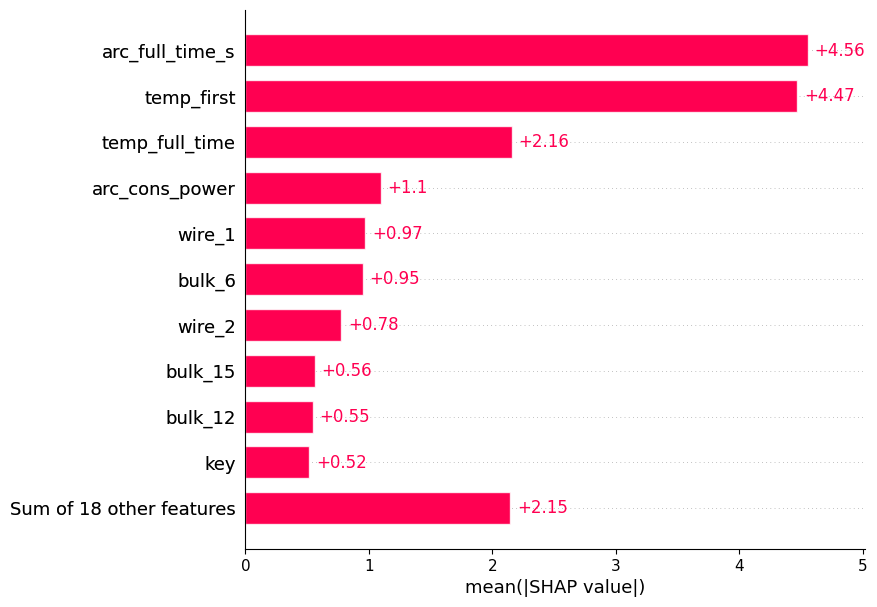



## **7. Основные выводы**.

Основные факторы, влияющие на температуру это первоначальная температура, время всего нагрева и энергетические характеристики (мощность). Управляя ими можно в значительной степени управлять энергоэффективностью сталелитейного производства. Также влияние имеют состав добавок и время их добавления. Так можно скорректировать изменение температуры. 

## **8. Заключение**.

В рамках данного отчета были даны ответы на следующие вопросы:

- были выполнены все пункты изначально намеченного плана. К нюансам реализации можно отнести предобработку датсетов data_arc.csv и data_temp.csv, в них были введены дополнительные параметры.

- Особых трудностей в процессе не было. Задачу регрессии мы выполнили, модель обучилась быстро, работа была объемная, но в целом типовая.

- С точки зрения выполненных работ, к ключевым шагам можно отнести очистку и объединение данных, в первую очередь. Обучение модели, тестирование и выводы так же можно считать ключевыми шагами в работе. С точки зрения бизнеса самым важным является перечень наиболее значимых параметров. Это то, на что влияя бизнес может снижать свои расходы и издержки.
